# Adding visualization

So far, we’ve built a model, run it, and analyzed some output afterwards. However, one of the advantages of agent-based models is that we can often watch them run step by step, potentially spotting unexpected patterns, behaviors or bugs, or developing new intuitions, hypotheses, or insights. Other times, watching a model run can explain it to an unfamiliar audience better than static explanations. Like many ABM frameworks, Mesa allows you to create an interactive visualization of the model. In this section we’ll walk through creating a visualization using built-in components, and (for advanced users) how to create a new visualization element.

First, a quick explanation of how Mesa’s interactive visualization works. Visualization is done in a browser window, using JavaScript to draw the different things being visualized at each step of the model. To do this, Mesa launches a small web server, which runs the model, turns each step into a JSON object (essentially, structured plain text) and sends those steps to the browser.

A visualization is built up of a few different modules: for example, a module for drawing agents on a grid, and another one for drawing a chart of some variable. Each module has a Python part, which runs on the server and turns a model state into JSON data; and a JavaScript side, which takes that JSON data and draws it in the browser window. Mesa comes with a few modules built in, and let you add your own as well.

Grid Visualization
To start with, let’s have a visualization where we can watch the agents moving around the grid. For this, you will need to put your model code in a separate Python source file; for example, ```MoneyModel.py```. Next, either in the same file or in a new one (e.g. ```MoneyModel_Viz.py```) import the server class and the Canvas Grid class (so-called because it uses HTML5 canvas to draw a grid). If you’re in a new file, you’ll also need to import the actual model object.

## Importing 


 If MoneyModel.py is where your code is:  
``` from MoneyModel import MoneyModel```  
Yo simplemente copiare la celdas y paquetes del modelo del tutorial introductivo del notebook anterior

In [10]:
#importando todos los modulos utilizados en el tutorial introductorio
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import numpy as np
import matplotlib.pyplot as plt
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [4]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, #función que se aplica a los agenes en cada paso
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    
    

In [7]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

#### Analisis hecho en el tutorial introductorio

In [8]:
model=MoneyModel(50,10,10)
for i in range(1000):
    model.step()

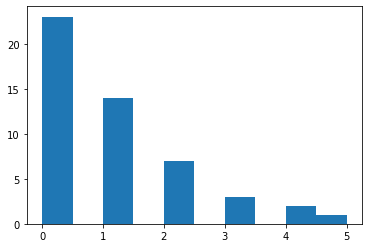

In [11]:
%matplotlib inline

agent_wealth = [a.wealth for a in model.schedule.agents] #list comprehension :)
plt.hist(agent_wealth)
#For a script add the following line
plt.show()

In [15]:
all_wealth = []
#This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(50,10,10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

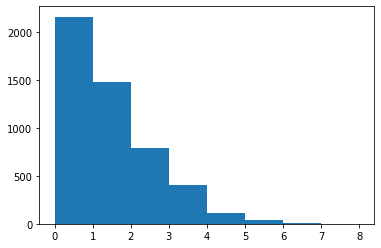

In [18]:
plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()

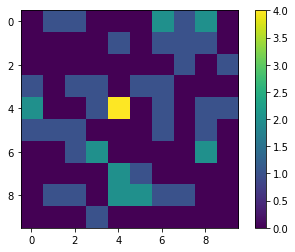

In [19]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()
plt.show()
# If running from a text editor or IDE, remember you'll need the following:
#plt.show()

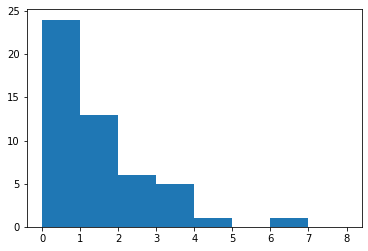

1

In [20]:
agent_wealths = [agent.wealth for agent in model.schedule.agents]
type(agent_wealths)
aw=np.array(agent_wealths) #using numpy for analysis
plt.hist(aw, bins=range(max(aw)+3))
plt.show()
np.count_nonzero(aw==4) #counting occurrencies in an array

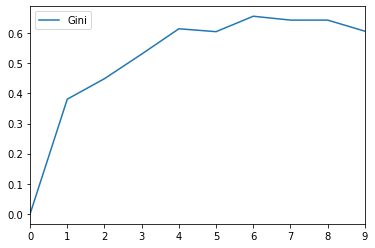

In [21]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.show()

## Empezando con el tutorial avanzado...

In [23]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

```CanvasGrid``` works by looping over every cell in a grid, and generating a portrayal for every agent it finds. A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.

In [41]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "#5BA822",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    return portrayal
#aqui puedo hacer una función rgb que asgne el color de acuerdo al vector de consumo 
# que tiene que ser un atributo individual en la clase del agente como el "wealth"


In addition to the portrayal method, we instantiate a canvas grid with its width and height in cells, and in pixels. In this case, let’s create a 10x10 grid, drawn in 500 x 500 pixels.

In [42]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

Now we create and launch the actual server. We do this with the following arguments:  

* The model class we’re running and visualizing; in this case, MoneyModel.
* A list of module objects to include in the visualization; here, just [grid]
* The title of the model: “Money Model”
* Any inputs or arguments for the model itself. In this case, 100 agents, and height and width of 10. 

Once we create the server, we set the port for it to listen on (you can treat this as just a piece of the URL you’ll open in the browser). Finally, when you’re ready to run the visualization, use the server’s launch() method.

Now run this file; this should launch the interactive visualization server and open your web browser automatically. (If the browser doesn’t open automatically, try pointing it at http://127.0.0.1:8521 manually. If this doesn’t show you the visualization, something may have gone wrong with the server launch.)

You should see something like the figure below: the model title, a grid filled with red circles representing agents, and a set of buttons to the right for running and resetting the model.

![Initial vis](https://mesa.readthedocs.io/en/master/_images/viz_redcircles.png)

**Cambiando a los agentes**

In the visualization above, all we could see is the agents moving around – but not how much money they had, or anything else of interest. Let’s change it so that agents who are broke (wealth 0) are drawn in grey, smaller, and above agents who still have money.

To do this, we go back to our ```agent_portrayal``` code and add some code to change the portrayal based on the agent properties.

In [48]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

Now launch the server again - this will open a new browser window pointed at the updated visualization. Initially it looks the same, but advance the model and smaller grey circles start to appear. Note that since the zero-wealth agents have a higher layer number, they are drawn on top of the red agents.

In [49]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

In [ ]:
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8528 # The default
server.launch()

#la cuenta del servidor hasta aqui sun june 14th 13:00 es 8528

**Adding a chart**  

Next, let’s add another element to the visualization: a chart, tracking the model’s Gini Coefficient. This is another built-in element that Mesa provides.

In [45]:
from mesa.visualization.modules import ChartModule

The basic chart pulls data from the model’s DataCollector, and draws it as a line graph using the Charts.js JavaScript libraries. We instantiate a chart element with a list of series for the chart to track. Each series is defined in a dictionary, and has a Label (which must match the name of a model-level variable collected by the DataCollector) and a Color name. We can also give the chart the name of the DataCollector object in the model.

Finally, we add the chart to the list of elements in the server. The elements are added to the visualization in the order they appear, so the chart will appear underneath the grid.

In [50]:
chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

In [ ]:
server.port = 8530 # The default
server.launch()

Launch the visualization and start a model run, and you’ll see a line chart underneath the grid. Every step of the model, the line chart updates along with the grid. Reset the model, and the chart resets too.

![](https://mesa.readthedocs.io/en/master/_images/viz_chart.png)

Note: You might notice that the chart line only starts after a couple of steps; this is due to a bug in Charts.js which will hopefully be fixed soon.

En este link se puede ver la visualización del modelo:
[visualización](http://127.0.0.1:8530/#)

# Referencias 

[Advanced Mesa Tutorial](https://mesa.readthedocs.io/en/master/tutorials/adv_tutorial.html)